# Conversion of Raw lidar data to cloud and precipitation classification

## Abstract

This Notebook contains the post processing of the lidar data, including the spatial and temporal integration, the system calibration, background correction, SNR estimation, volume depolarization estimation, Cloud masking and hidrometeor clasification. Quick looks and some statistics are generated as well. Results are saved in netCDF format.

## Import libraries

Generic and own packages stored in "lib" are loaded to be used along the notebook. 

In [1]:
import sys, os
sys.path.append("lib") # adding "lib" path with own packages
from Sigma_mol import sigma_mol # reads the radio sounsing and compute extinction coefficient
from scipy.interpolate import interp1d # to interpolate modeled variables to lidar heights
from lidar_integrating_space_time import Lidar_space_time as lidar_integ #integrates lidar raw data in height and time
from fft_denoising import fft_denoising #maybe not used
from klett import Klett81b #maybe not used
import numpy as np 
import pylab #plots
from DP_simp import DP_simp # Curve simplification
from running_mean import running_mean # runing mean
from time2epoch import time2epoch #maybe not used?
#from cloud_mask_v1 import cloud_mask
from netCDF4 import Dataset 
#from time import sleep
from scipy import stats
from scipy.optimize import curve_fit
from dplots import densplot # make 2D desity plots
from Comb_LidarMRR import Comb_LidarMRR4 as Comb_LidarMRR 
from cloud_mask_v2 import cloud_mask2
from sm_paramTOP import sm_paramTOP
import matplotlib
from copy import copy
from BG_corr import BG_corr
import time
from calendar import timegm

## Load MRR and other parameters

Load MRR data during the period of study. It also configures the font format and color maps

In [2]:
##### output Temporal RESolution
TRES = 10 #min. 

##### output Vertical RESolution
VRES = 6 #bins, 1bin = 3.8m # try only 1,2,3,6 bins

#####Load MRR Data
path_MRR = "I:/PHD/Lidar/Inversion_V2/MRR_Data/"
Ze = np.loadtxt(path_MRR + "Ze_"+str(TRES)+"min.txt")
times_MRR = np.loadtxt(path_MRR + "times_"+str(TRES)+"min.txt")
Height_MRR = np.loadtxt(path_MRR + "Height.txt")

Zem = np.ma.masked_where(Ze == -9999, Ze)

#####Load font format

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}
        
pylab.rc('font', **font)      

#####Color Parameters
cmap = pylab.cm.jet
bounds = np.linspace(1,3,4)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
bounds2 = np.linspace(0,12,14)
norm2 = matplotlib.colors.BoundaryNorm(bounds2, cmap.N)

cmap2 = pylab.cm.get_cmap(cmap.name,8)

## Temporal and vertical integration

In [ ]:

##### Dates
#[ini, end]
year0 = [2017, 2017]
month0 = [9,12]
day0 = [1,31]
t0 = time.time()
##### Routine
for year in range(year0[0],year0[1]+1):
    for month in range(month0[0],month0[1]+1):
        for day in range(day0[0],day0[1]+1):
    
            path_out = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
            filename1 = path_out+"Par90/Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename2 = path_out+"Par10/Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename3 = path_out+"Per/Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            
            filename4 = path_out+"Nprofiles/Nprofiles_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min"+".dat"
            
            if os.path.isfile(filename1):
                #Par90 = np.loadtxt(filename1)
                #Par10 = np.loadtxt(filename2)
                #Per   = np.loadtxt(filename3)
                #r   = np.loadtxt(path_out+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
                #npt = np.loadtxt(filename4)
                print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data loaded"

            else:
                try:
                    mat = lidar_integ(date = str(year)+"."+str(month).zfill(2)+"."+str(day).zfill(2), space = VRES, timee = TRES, 
                              path = "G:/PC_chantal_20190131/MCS6A Data/")
                except:
                    continue
                    #print "what"
                print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data loaded"
                #sleep(8)
                np.savetxt(filename1,mat[0])
                np.savetxt(filename2,mat[1])
                np.savetxt(filename3,mat[2])
                #np.savetxt(path_out+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat",mat[3])
                np.savetxt(filename4,mat[4])
                #Par90 = mat[0]
                #Par10 = mat[1]
                #Per = mat[2]
                #npt = mat[4]
print "Elapsed time = ", (time.time() - t0)

## Background correction and SNR

In [15]:
for count in range(1):
    if count > 0: print "Next iteration"
    ##### Dates
    #[ini, end]
    year0 = [2017,2017]
    month0 = [2,12]
    day0 = [1,31]

    ##### Routine
    for year in range(year0[0],year0[1]+1):
        for month in range(month0[0],month0[1]+1):
            for day in range(day0[0],day0[1]+1):

                path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
                filename1 = path_in+"Par90/Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename2 = path_in+"Par10/Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename3 = path_in+"Per/Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename4 = path_in+"Nprofiles/Nprofiles_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min"+".dat"

                path_out = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
                
                filename5 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename6 = path_in+"Par10_bc/Par10bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename7 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

                filename8 = path_in+"SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename9 = path_in+"SNR/SNR_Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename10 = path_in+"SNR/SNR_Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

                filename11 = path_in+"Background/BG_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename12 = path_in+"Background/BG_Par10_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename13 = path_in+"Background/BG_Per_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                
                if os.path.isfile(filename13):
                    #print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data ready"
                    continue
                
                if os.path.isfile(filename1):
                    Par90 = np.loadtxt(filename1)
                    Par10 = np.loadtxt(filename2)
                    Per   = np.loadtxt(filename3)
                    r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
                    npt = np.loadtxt(filename4)

                    BG1 = np.zeros(shape = np.shape(Par90)[0])
                    BG10 = np.zeros(shape = np.shape(Par90)[0])
                    BG2 = np.zeros(shape = np.shape(Par90)[0])

                    print str(year)+str(month).zfill(2)+str(day).zfill(2)+" Data loaded"
                else:
                    #print "File not found"
                    continue

                Par_bc = np.zeros(shape = np.shape(Par90))
                Par10_bc = np.zeros(shape = np.shape(Par90))
                Per_bc = np.zeros(shape = np.shape(Per))
                SNR_par = np.zeros(shape = np.shape(Per))
                SNR_par10 = np.zeros(shape = np.shape(Per))
                SNR_per = np.zeros(shape = np.shape(Per))

                for i in range(np.shape(Par90)[0]):
                    try:
                        BG1[i] = BG_corr(Par90[i,:],r[:],year, month, day,rcf0 = 9,pol = 'parallel')[0][1]
                        BG10[i] = BG_corr(Par10[i,:],r[:],year, month, day,rcf0 = 9,pol = 'parallel')[0][1]
                        BG2[i] = BG_corr(Per[i,:],r[:],year, month, day,rcf0 = 9,pol = 'perpendicular')[0][1]  
                    except:
                        continue
                        
                    if BG1[i] < 0: BG1[i] = 0
                    if BG10[i] < 0: BG10[i] = 0
                    if BG2[i] < 0: BG2[i] = 0

                    if BG1[i] > np.nanmean(Par90[i,-50:]): BG1[i] = np.nanmean(Par90[i,-50:])
                    if BG10[i] > np.nanmean(Par10[i,-50:]): BG10[i] = np.nanmean(Par10[i,-50:])
                    if BG2[i] > np.nanmean(Per[i,-50:]): BG2[i] = np.nanmean(Per[i,-50:])

                    Par_bc[i,:] = Par90[i,:]-BG1[i]
                    Par10_bc[i,:] = Par10[i,:]-BG10[i]
                    Per_bc[i,:] = Per[i,:]-BG2[i]  

                    SNR_par[i,:] = (Par_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Par_bc[i,:]+2*(BG1[i]))**0.5
                    SNR_par10[i,:] = (Par10_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Par10_bc[i,:]+2*(BG10[i]))**0.5
                    SNR_per[i,:] = (Per_bc[i,:]*(npt[i]*TRES*6)**0.5)/(Per_bc[i,:]+2*(BG2[i]))**0.5

                    Par_bc[i,:] = (Par_bc[i,:])*r**2
                    Par10_bc[i,:] = (Par10_bc[i,:])*r**2
                    Per_bc[i,:] = (Per_bc[i,:])*r**2  

                np.savetxt(filename5,Par_bc)
                np.savetxt(filename6,Par10_bc)
                np.savetxt(filename7,Per_bc)

                np.savetxt(filename8,SNR_par)
                np.savetxt(filename9,SNR_par10)
                np.savetxt(filename10,SNR_per)

                np.savetxt(filename11,BG1)
                np.savetxt(filename12,BG10)
                np.savetxt(filename13,BG2)
    #print "waiting 15 minutes..."
    #time.sleep(15*60)
    #print "iteration = ", count
    #month00 = month

## Calibration system 

In [22]:
## load Calibration parameters
txt = open("I:/PHD/Lidar/Processing_V3/Calibration_sys/CalSys_"+str(TRES)+"min_"+str(VRES)+"bins_1.csv","r")
CalSys_header = txt.readline()

CalSys_time = []
CalSys_Cpar = []
CalSys_Cper = []
CalSys_K = []

for l in txt.readlines():
    CalSys_time.append(float(l.split(",")[1]))
    CalSys_Cpar.append(float(l.split(",")[3]))
    CalSys_Cper.append(float(l.split(",")[4]))  
    CalSys_K.append(float(l.split(",")[5]))  
    
CalSys_time = np.array(CalSys_time)
CalSys_Cpar = np.array(CalSys_Cpar)
CalSys_Cper = np.array(CalSys_Cper)
CalSys_K    = np.array(CalSys_K)

# overlapping function
path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"

#O = np.loadtxt(path_in + "Overlapping_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
#Or = np.loadtxt(path_in + "Overlapping_"+str(TRES)+"min_"+str(VRES)+"bins_R.dat")
O = np.loadtxt(path_in+"Overlapping_"+str(TRES)+"min_"+str(VRES)+"bins_08032017_14UTC2.dat")
Or = np.loadtxt(path_in+"Overlapping_"+str(TRES)+"min_"+str(VRES)+"bins_08032017_14UTC_r2.dat")
##### Signal, X and Depolarization calibration
year0 = [2017,2017]
month0 = [2,8]
day0 = [1,31]

for year in range(year0[0],year0[1]+1):
    for month in range(month0[0],month0[1]+1):
        for day in range(day0[0],day0[1]+1):

            filename1 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename2 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            path_out = "I:/PHD/Lidar/Processing_V3/SysCalibrated/"+str(TRES)+"min"+str(VRES)+"bins/"
            
            if (os.path.isdir(path_out+"Bpar") == False): os.makedirs(path_out+"Bpar")
            if (os.path.isdir(path_out+"Bper") == False): os.makedirs(path_out+"Bper")
            if (os.path.isdir(path_out+"DepRatio") == False): os.makedirs(path_out+"DepRatio")
            if (os.path.isdir(path_out+"X") == False): os.makedirs(path_out+"X")

            filename3 = path_out+"Bpar/Bpar_sc_O_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename4 = path_out+"Bper/Bper_sc_O_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename5 = path_out+"DepRatio/DepRatio_sc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename6 = path_out+"X/X_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

            if os.path.isfile(filename6):
                continue
            if os.path.isfile(filename1):
                Par = np.loadtxt(filename1)
                Per = np.loadtxt(filename2)
                r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
                
                utc_time = time.strptime(str(year)+"-"+str(month).zfill(2)+"-"+str(day).zfill(2)+" "+"00:00:00", "%Y-%m-%d %H:%M:%S")
                epoch_time = timegm(utc_time)
                
                pix_cal = np.squeeze(np.where(abs(CalSys_time-epoch_time) == np.min(abs(CalSys_time-epoch_time))))
                
                Cpar = np.mean(CalSys_Cpar[pix_cal])
                Cper = np.mean(CalSys_Cper[pix_cal])
                
                #Attenuated Backscatter coefficient
                Bpar = Par/Cpar
                Bper = Per/Cper
                
                #Linear Depolarization Ratio
                DepRatio = (Bper/Bpar)
                
                #Overlapping Correction
                
                Bpar_O = np.zeros(shape = np.shape(Par[:,int(11*3./VRES):]))
                Bper_O = np.zeros(shape = np.shape(Per[:,int(11*3./VRES):]))
                
                for j in range(np.shape(Par)[0]):
                    Bpar_O[j,:] = Bpar[j,int(11*3./VRES):]*O 
                    Bper_O[j,:] = Bper[j,int(11*3./VRES):]*O 
                
                #Attenuation between consecutive layers: X
                X = np.zeros(shape = np.shape(Bpar_O))

                for i in range(15,np.size(Or)-2):
                    X[:,i] = np.log10(Bpar_O[:,i]/Bpar_O[:,i+1])
                
                #save Data
                np.savetxt(filename3,Bpar_O)
                np.savetxt(filename4,Bper_O)
                np.savetxt(filename5,DepRatio)
                np.savetxt(filename6,X)
                
                

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:86: RuntimeWarning: invalid value encountered in log10
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning: divide by zero encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:86: RuntimeWarning: divide by zero encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:86: RuntimeWarning: divide by zero encountered in log10
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:86: RuntimeWarning: invalid value encountered in divide
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning: invalid value encountered in divide


## Cloud Masking

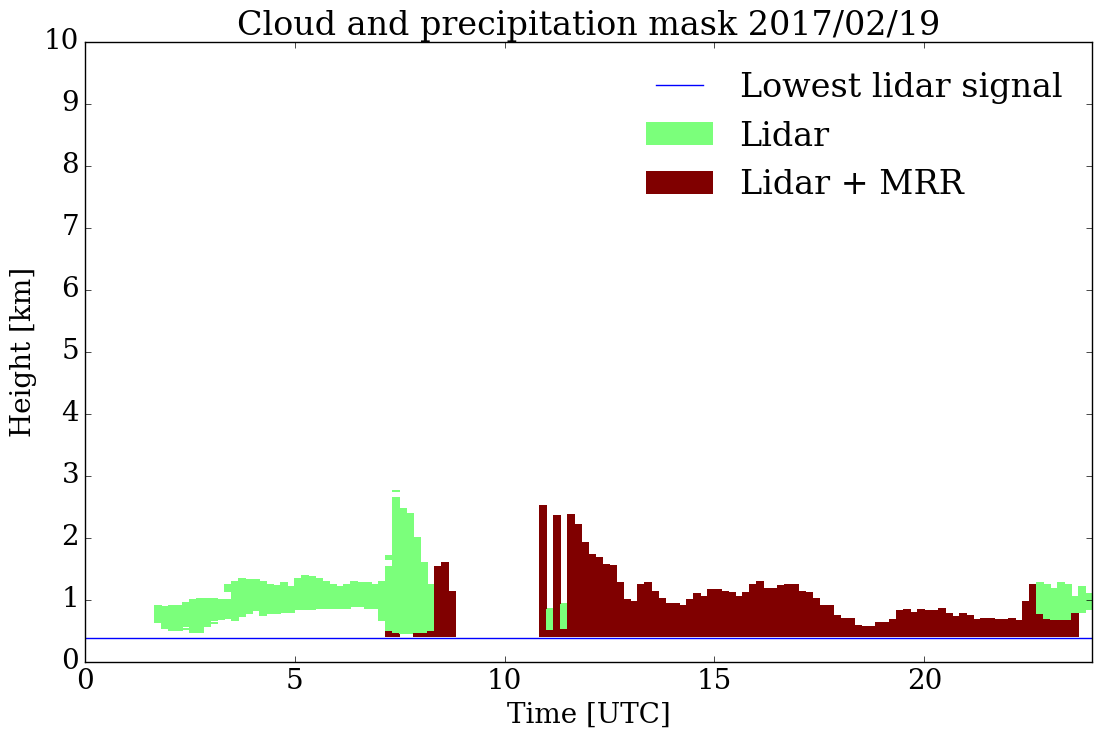

In [5]:
##### Dates 
year0 = [2017,2017]
month0 = [2,2]
day0 = [19,19]

#### Parameters
SNR_threshold = 10 # threshold of SNR (based on Par90 SNR)
nstd = 3 # number of standard deviations in the curve simplification
sm= 5 # window for the temporal moving average
dPlot = False #do plots
check = False # internal code to check step by step the masking algorithm
slr = 0
th = 1.1#4

path_in = "I:/PHD/Lidar/Processing_V3/SysCalibrated/"+str(TRES)+"min"+str(VRES)+"bins/"

r = np.loadtxt("I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/Overlapping_"+str(TRES)+"min_"+str(VRES)+"bins_R.dat")

for year in range(year0[0],year0[1]+1):
    for month in range(month0[0],month0[1]+1):
        for day in range(day0[0],day0[1]+1):

            filename1 = path_in+"Bpar/Bpar_sc_O_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename2 = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/SNR/SNR_Par90_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            filename6 = "C"    
            if os.path.isfile(filename6):
                continue

            if os.path.isfile(filename1):

                Par = np.loadtxt(filename1)[:,int(20.*3./VRES):]
                BASES = np.zeros(shape = (np.size(Par[:,0]),20))
                TOPS = np.zeros(shape = (np.size(Par[:,0]),20))
                Data_mask = np.zeros(shape = np.shape(Par))
                SNR = np.loadtxt(filename2)
                SNR = SNR[:,int(11*3./VRES):][:,int(20.*3./VRES):]

                dbins = np.size(r)-np.size(Par[0,:])
                R = r[dbins:]#_[3:][15:]
                r_ = R#_[3:][15:] # This had sence in previous version of the code =)

                minR = R[1]
                minR_Ze = np.squeeze(np.where(abs(Height_MRR - minR) == min(abs(Height_MRR - minR))))
    
                for h in range(np.shape(Par)[0]):
                    #print h    
                    Y2 = Par[int(h),:]##Y2[15:]
                    
                    AA=running_mean(Y2,sm)#[sm-1:]
                    rr=R[(sm-1)/2:-(sm-1)/2]#pd.rolling_mean(r,sm)[sm-1:]

                    pix=np.squeeze(np.where(AA <0))

                    AAA = np.zeros(shape = np.size(AA)-1)
                    sum = 0
                    for i0 in np.linspace(np.size(AA)-2,0,np.size(AA)-1):
                        i = int(i0)
                        #print i,AA[i],AA[i+1]
                        if ((AA[i]>0) & (AA[i+1]>0)):
                            sum = sum+1
                            #print sum
                            AAA[i]=sum
                        else:
                            sum = 0
                            AAA[i]=sum    

                    AAA[1:] = AAA[1:]-AAA[0:-1]

                    pix2 = np.squeeze(np.where(AAA > 20))

                    if np.size(pix2)>1:

                        deltaH = 0
                        for nlayer in range(np.size(pix2)):
                            #print "nlayer",nlayer

                            rrr = rr[pix2[nlayer]:pix2[nlayer]+int(AAA[pix2[nlayer]])+1]

                            pix3=np.squeeze(np.where((R[:-1] >= rrr[0]) & (R[:-1] <rrr[-1])))#r_[3:-1]

                            Y3 = Y2[pix3[0]-(sm-1)/2:pix3[-1]+(sm-1)/2+2]
                            R3 = R[pix3[0]-(sm-1)/2:pix3[-1]+(sm-1)/2+2]
                            
                            c_mask, baseH, topH, layers, layers_mask = cloud_mask2(Y3,R3,doPlot = dPlot, th = th,nstd=nstd, sm = sm, check = check)

                            #Previous definition of Data Threshold
                            Data_mask[int(h),np.squeeze(np.where(r_ == np.nanmin(R3))):np.squeeze(np.where(r_ == np.nanmax(R3)))+1] = 1.
                            if np.sum(baseH) != -9999:
                                #print baseH,topH
                                BASES[int(h),0+deltaH:np.size(baseH)+deltaH] = baseH
                                TOPS[int(h),0:np.size(topH)+deltaH] = topH
                                deltaH = np.size(baseH)

                    elif np.size(pix2)>=1:

                        rrr = rr[pix2:pix2+int(AAA[pix2])+1]

                        pix3=np.squeeze(np.where((R[:-1] >= rrr[0]) & (R[:-1] <rrr[-1]))) #r_[3:-1]

                        Y3 = Y2[pix3[0]-(sm-1)/2:pix3[-1]+(sm-1)/2+2]
                        R3 = R[pix3[0]-(sm-1)/2:pix3[-1]+(sm-1)/2+2] #r_
                                                
                        #Previous definition of Data Threshold
                        Data_mask[int(h),np.squeeze(np.where(r_ == np.nanmin(R3))):np.squeeze(np.where(r_ == np.nanmax(R3)))+1] = 1.

                        c_mask, baseH, topH, layers, layers_mask = cloud_mask2(Y3,R3,doPlot = dPlot, th = th,nstd=nstd, sm = sm, check = check)

                        if np.sum(baseH) != -9999:
                            BASES[int(h),0:np.size(baseH)] = baseH
                            TOPS[int(h),0:np.size(topH)] = topH            
                 
                #pylab.show()
                #stop
                ###### SNR threshold
                Data_mask = Data_mask*(SNR[:,:]>SNR_threshold)

                ###### Create CLOUD MASK
                TOPSma = np.ma.masked_where(TOPS==0,TOPS) 
                BASESma = np.ma.masked_where(BASES==0,BASES) 

                Cloud_ma = np.zeros(shape = (np.size(Par[:,1]), np.size(r_[:])))
                #Cloud_ma_index = np.zeros(shape = np.shape(Cloud_ma))
                Cloud_ma_indexb = np.zeros(shape = np.shape(Cloud_ma))

                for i in range(np.size(Par[:,1])):
                    for j in range(20):
                        #condition1 = np.bitwise_and(np.uint64(eerr > 0) , np.uint64(nwl < 100))
                        #
                        pix = np.squeeze(np.where(np.uint64(r_[:] >= BASESma[i,j]) & np.uint64(r_[:] <= TOPSma[i,j])))
                        for j2 in pix:
                            Cloud_ma[i,j2] = 1 

                for i in range(np.shape(Cloud_ma)[0]-4):
                    for j in range(np.shape(Cloud_ma)[1]-4):
                        val = np.sum(Cloud_ma[i,j-1:j+2])+np.sum(Cloud_ma[i+1,j-1:j+2])+np.sum(Cloud_ma[i+3,j-1:j+2])+np.sum(Cloud_ma[i+4,j-1:j+2])
                        Cloud_ma_indexb[i+2,j+2] =val*Cloud_ma[i+2,j+2] 
                for j in range(np.shape(Cloud_ma)[1]-2):
                    Cloud_ma_indexb[0,j+2] = Cloud_ma[0,j+2]*(2+np.sum(Cloud_ma[1:3,j-1:j+2]))
                    Cloud_ma_indexb[1,j+2] = Cloud_ma[0,j+2]*(2+np.sum(Cloud_ma[1:4,j-1:j+2]))
                    Cloud_ma_indexb[-1,j+2] = Cloud_ma[-1,j+2]*(2+np.sum(Cloud_ma[-3:-1,j-1:j+2]))    
                    Cloud_ma_indexb[-2,j+2] = Cloud_ma[-2,j+2]*(2+np.sum(Cloud_ma[-4:-2,j-1:j+2]))    

                Cloud_mask2 = Cloud_ma_indexb > 6    

                hours = np.linspace(0,24,np.size(Par[:,1]))

                ###### Filter Data_mask and create layer mask
                Data_index = np.zeros(shape= np.shape(Data_mask))

                for i in range(np.shape(Cloud_ma)[0]-2):
                    for j in range(np.shape(Cloud_ma)[1]-2):
                        val = np.sum(Data_mask[i,j-1:j+2])+np.sum(Data_mask[i+2,j-1:j+2])
                        Data_index[i+1,j+1] =val*Data_mask[i+1,j+1] 
                for j in range(np.shape(Cloud_ma)[1]-2):
                    Data_index[0,j+1] = Data_mask[0,j+1]*(1+np.sum(Data_mask[1,j-1:j+2]))
                    Data_index[-1,j+1] = Data_mask[-1,j+1]*(1+np.sum(Data_mask[-2,j-1:j+2]))   

                layers_mask = (Data_index>3)[:,:]+1*Cloud_mask2  
                layers_mask = np.ma.masked_where(layers_mask==0,layers_mask)  
                
                layers_mask2 = Comb_LidarMRR(layers_mask, Par,R,nstd,sm,times_MRR, Ze, year, month, day, hours, TRES=TRES, VRES=VRES, minR_Ze=minR_Ze)
                layers_mask3 = np.ma.masked_where(layers_mask2 == 1, layers_mask2) 
                cmaps = pylab.cm.get_cmap(cmap.name,3)        
                fig, ax1 = pylab.subplots(figsize=(13,8))
                pylab.pcolor(hours,r_,np.transpose(layers_mask3),vmin=1,vmax=3, cmap=cmaps)
                pylab.bar([-11,-12],[0,0], label = "Lidar", color = cmaps(1),edgecolor = "none")
                pylab.bar([-11,-12],[0,0], label = "Lidar + MRR", color = cmaps(3),edgecolor = "none")
                pylab.plot([0,24],[R[1],R[1]], label = "Lowest lidar signal")
                pylab.axis([0,24,0,10])
                pylab.yticks(np.linspace(0,10,11))
                pylab.xlabel("Time [UTC]")
                pylab.ylabel("Height [km]")
                pylab.title("Cloud and precipitation mask " +str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2))
                pylab.legend(frameon = False)
                pylab.savefig("I:/PHD/Lidar/Processing_V3/Cloud_mask/"+str(TRES)+"min"+str(VRES)+"bins/Plots/MASK_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.png",format="png",bbox_inches = 'tight', dpi=300)
                pylab.show()
                np.savetxt("I:/PHD/Lidar/Processing_V3/Cloud_mask/"+str(TRES)+"min"+str(VRES)+"bins/MASK_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.txt", layers_mask2)

np.savetxt("I:/PHD/Lidar/Processing_V3/Cloud_mask/R_"+str(TRES)+"min_"+str(VRES)+"bins_masked.dat",r_)

In [15]:
path_out2 + "Dispersion_"+str(year)+str(month).zfill(2)+str(day0[0]).zfill(2) +"_" +str(year)+str(month).zfill(2)+str(day0[0]+ndays-1).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.png"

'I:/PHD/Lidar/Processing_V3/Cloud_Classification/Plots/Dispersion_20170226_20170228_10min_6bins.png'

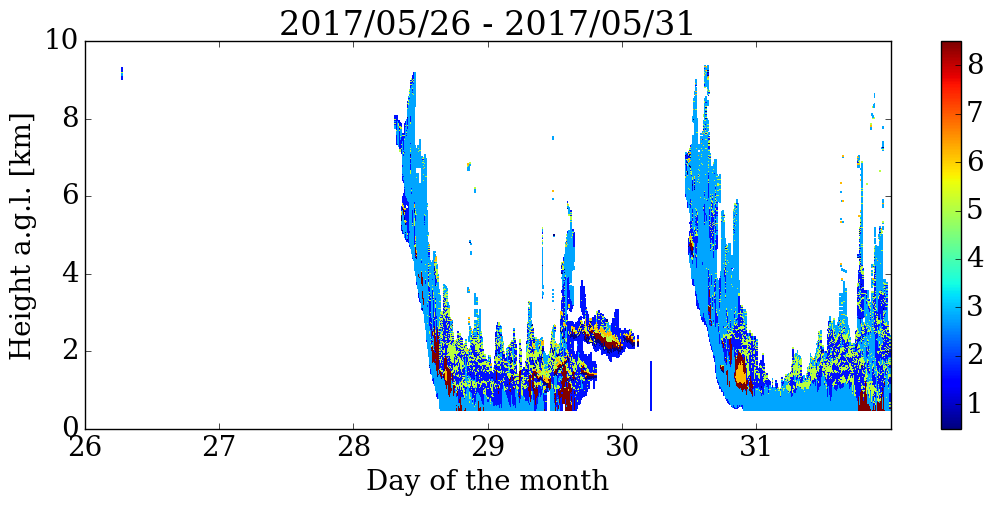

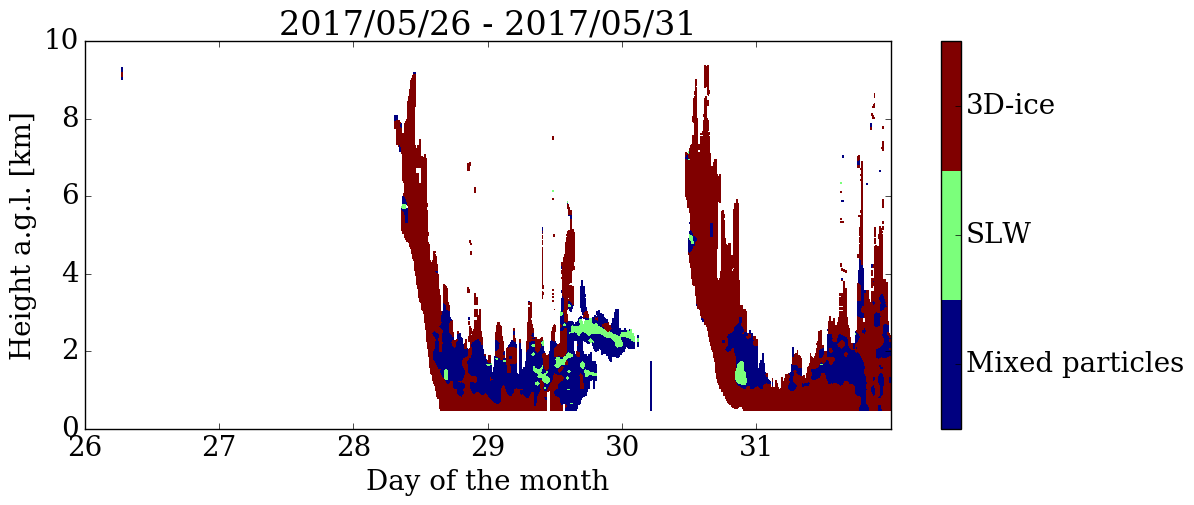

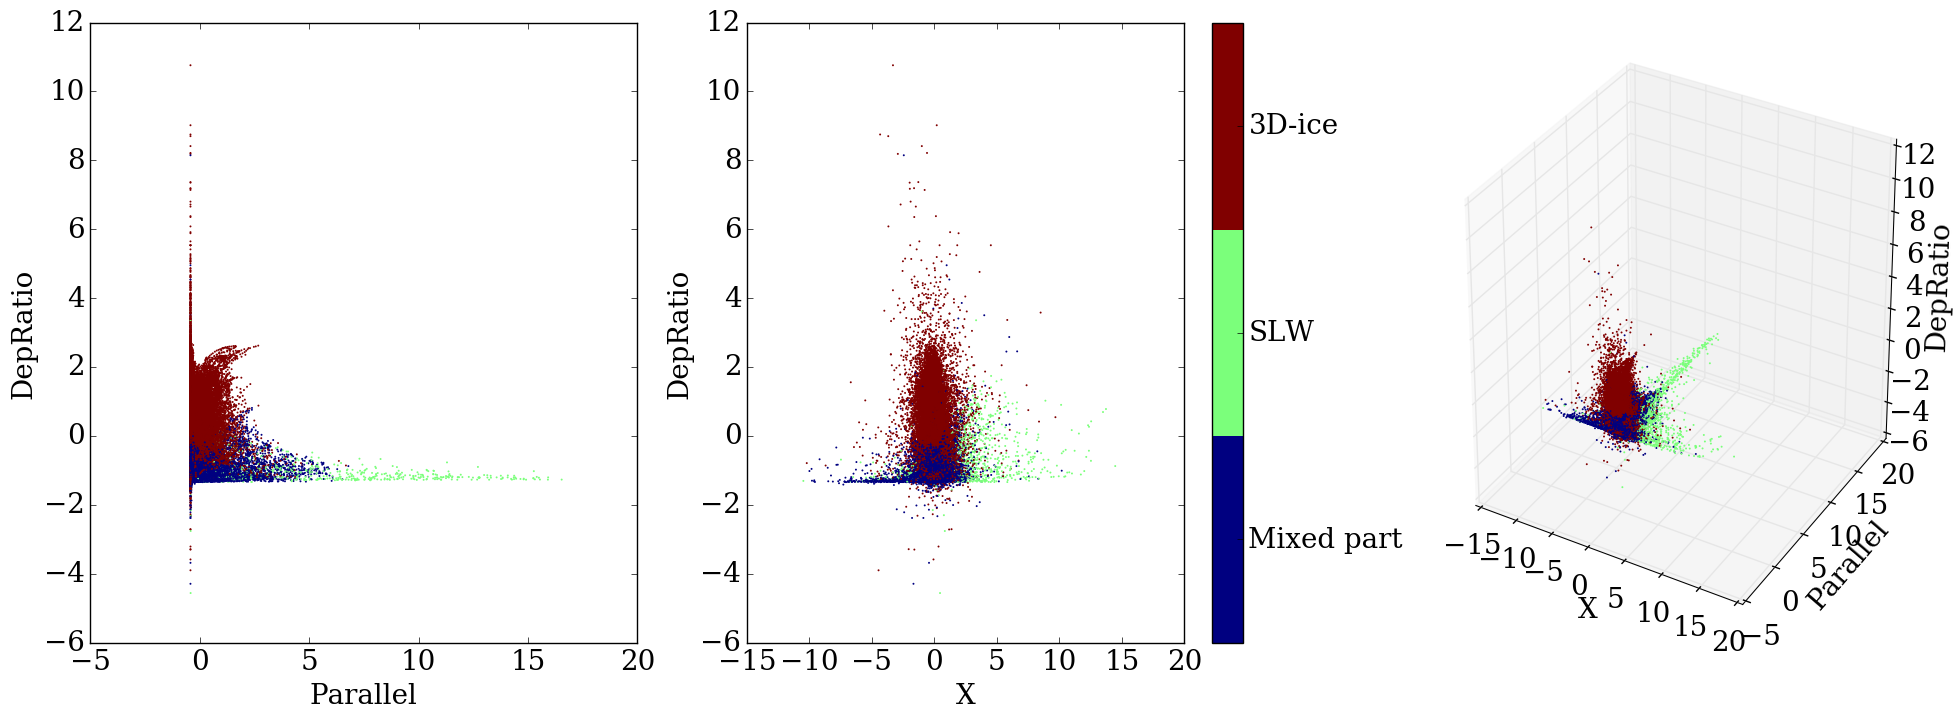

In [17]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

##### Dates 
    
year0 = [2017,2017]
month0 = [5,5]
ndays = 5

dmax = np.array([31,28,31,30,31,30,31,31,30,31,30,31])

ndaysmax = dmax-26+1

nclusters = 8

path_in = "I:/PHD/Lidar/Processing_V3/SysCalibrated/"+str(TRES)+"min"+str(VRES)+"bins/"

r = np.loadtxt("I:/PHD/Lidar/Processing_V3/Cloud_mask/R_"+str(TRES)+"min_"+str(VRES)+"bins_masked.dat")

for year in range(year0[0],year0[1]+1):
    for month in range(month0[0],month0[1]+1):
        for day00 in [26]: #[1,6,11,16,21,26]
            
            var1 = []
            var2 = []
            var3 = []
            Mask_ = []            
            
            if day00 < 26: ndays = 5
            if day00 == 26: ndays = ndaysmax[month-1]
            
            day0 = [day00,day00]
            
            path_out1 = "I:/PHD/Lidar/Processing_V3/Cloud_Classification/10min6bins/"
            filename5 = path_out1 + "Class_"+str(year)+str(month).zfill(2)+str(day0[0]).zfill(2) +"_" +str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
            
            path_out2 = "I:/PHD/Lidar/Processing_V3/Cloud_Classification/Plots/"
            filename6 = path_out2 + "Class_"+str(year)+str(month).zfill(2)+str(day0[0]).zfill(2) +"_" +str(year)+str(month).zfill(2)+str(day0[0]+ndays-1).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.png"
            filename7 = path_out2 + "Dispersion_"+str(year)+str(month).zfill(2)+str(day0[0]).zfill(2) +"_" +str(year)+str(month).zfill(2)+str(day0[0]+ndays-1).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.png"
            
            for day in range(day0[0],day0[1]+ndays):

                path_in1 = "I:/PHD/Lidar/Processing_V3/SysCalibrated/"+str(TRES)+"min"+str(VRES)+"bins/"
                path_in2 = "I:/PHD/Lidar/Processing_V3/Cloud_mask/"+str(TRES)+"min"+str(VRES)+"bins/"

                filename1 = path_in1 + "DepRatio/DepRatio_sc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename2 = path_in1 + "Bpar/Bpar_sc_O_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename3 = path_in1 + "X/X_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
                filename4 = path_in2 + "MASK_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.txt"

                DepRatio = np.loadtxt(filename1)[:,int(11.*3./VRES):][:,int(20.*3./VRES):]
                Bpar = np.loadtxt(filename2)[:,int(20.*3./VRES):]
                X = np.loadtxt(filename3)[:,int(20.*3./VRES):]
                Mask = np.loadtxt(filename4)

                pix = np.where(((Mask == 2) | (Mask == 3)) & (X>-9999)& (X!=0))

                #pylab.pcolor(np.transpose(np.ma.masked_where(((Mask == 2) | (Mask == 3)) & (X>-9999)& (X!=0),Mask)))#,vmin=0,vmax=0.1)
                #pylab.show()            
                #pylab.pcolor(np.transpose(Mask))#,vmin=-1,vmax=1)
                #pylab.colorbar()
                #pylab.show()               
                var1 = var1+list(X)#[pix])
                var2 = var2+list(DepRatio)#[pix])
                var3 = var3+list(Bpar)#[pix])
                Mask_= Mask_+list(Mask)#[pix])

                #print np.size(var1)

            var1_ = np.array(var1) 
            var2_ = np.array(var2)
            var3_ = np.array(var3)
            Mask_ = np.array(Mask_)

            pix0 = (((Mask_ == 2) | (Mask_ == 3)) & (var1_>-9999)& (var1_!=0))
            pix2 = np.where(pix0)

            var1 = var1_[pix2]  
            var2 = var2_[pix2]  
            var3 = var3_[pix2]  

            vvar1 = (var1-np.nanmean(var1))/np.nanstd(var1)
            vvar2 = (var2-np.nanmean(var2))/np.nanstd(var2)
            vvar3 = (var3-np.nanmean(var3))/np.nanstd(var3)

            XX = np.array([vvar1,vvar2,vvar3])
            XX = XX.T

            init0 = np.loadtxt("I:/PHD/Lidar/Inversion_V2/Cloud_Classification/Clustering/Models_means_GMM_1month_"+str(nclusters)+"clss_kmeans_"+str(month).zfill(2)+str(year).zfill(4)+"_centers.txt")

            model = KMeans(n_clusters=nclusters,init=init0)
            model.fit(XX)

            c = model.labels_+1

            clus = np.zeros(shape = np.shape(var1_))

            clus[pix2] = c

            #clus[np.where((var2_ <=0.03/5))] = 9

            xx2 = np.ma.masked_where(~pix0,var1_)
            yy2 = np.ma.masked_where(~pix0,var2_)
            clus = np.ma.masked_where(~pix0,clus)

            clus8 = copy(clus)

            clus[clus == 7] = 3
            clus[clus == 4] = 6

            hours2 = np.linspace(0,24*ndays,ndays*np.size(X[:,1]))

            fig, ax1 = pylab.subplots(figsize = (13,5))
            pylab.pcolor(hours2,r,np.transpose(clus))
            cbar  = pylab.colorbar(cmap=cmap2, spacing='proportional',ticks=(np.linspace(1+7/16.,8-7/16.,8))) #, format='%1i'
            cbar.ax.set_yticklabels(['1', '2', '3', '4', '5', '6', '7', '8']) 
            pylab.xticks(np.linspace(0,24*ndays,ndays+1)[:-1],np.array(np.linspace(day0[0],day0[0]+ndays,ndays+1),dtype = int)[:-1])
            pylab.xlabel('Day of the month')
            pylab.ylabel('Height a.g.l. [km]')
            pylab.axis([0,24*ndays,0,10])
            pylab.title(str(year)+"/"+str(month).zfill(2)+"/"+str(day0[0]).zfill(2) +" - " +str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2)
            )
            pylab.show()

            clus2 = copy(clus)

            clus3 = copy(clus2)               

            for i in range(1,np.shape(clus2)[0]-1):
                for j in range(1,np.shape(clus2)[1]-1):
                    #cls = clus2[i-2:i+2+1,j-2:j+2+1]
                    cls = clus2[i-1:i+1+1,j-1:j+1+1]
                    if (clus2[i,j] in [1,2,5,8]):
                        n1 = np.size(np.where(cls == 3))
                        n2 = np.size(np.where(cls == 6))
                        n3 = np.size(np.where(cls == 9))

                        ns = np.array([n1,n2,n3]) #,n4,n5
                        if np.sum(ns) > 0:
                            mjs = np.squeeze(np.where(ns == np.max(ns)))
                            if np.size(mjs) == 1:
                                clus3[i,j] = (mjs+1)*3

            clus4 = copy(clus3) 

            for i in range(2,np.shape(clus3)[0]-2):
                for j in range(2,np.shape(clus3)[1]-2):
                    cls = clus3[i-2:i+2+1,j-2:j+2+1]
                    #cls = clus3[i-1:i+1+1,j-1:j+1+1]
                    cls = cls.filled(0)[(cls.filled(0)!=0) & (cls.filled(0)!=10)]
                    if (np.size(cls)>1) & (clus3.mask[i,j] == False):
                        Majority = stats.mode(np.reshape(cls[cls>0],np.size(cls[cls>0]))).mode[0]
                        nMajority = stats.mode(np.reshape(cls[cls>0],np.size(cls[cls>0]))).count[0]
                        if nMajority > 0.5*(np.size(cls)):
                            clus4[i,j] = Majority 
                        else:
                            clus4[i,j] = 1

            clus3 = np.ma.masked_where(xx2.mask == True,clus4)

            clus3[clus3 == 1] = 10
            clus3[clus3 == 2] = 10
            clus3[clus3 == 4] = 10
            clus3[clus3 == 5] = 10
            clus3[clus3 == 8] = 10

            #clus3[clus3 == 9] = 2
            clus3[clus3 == 3] = 3
            clus3[clus3 == 10] = 1            
            clus3[clus3 == 6] = 2
            
            cmap3 = pylab.cm.get_cmap(cmap.name,3)

            fig, ax1 = pylab.subplots(figsize = (13,5))
            pylab.pcolor(hours2,r,np.transpose(clus3),cmap=cmap3)#cmap=plt.cm.nipy_spectral)
            #cbar  = pylab.colorbar(cmap=cmap3, spacing='proportional',ticks=(np.linspace(1+3/8.,4-3/8.,4))) #, format='%1i'
            cbar  = pylab.colorbar(cmap=cmap3, spacing='proportional',ticks=(np.linspace(1+2/6.,3-2/6.,3))) #, format='%1i'
            pylab.xticks(np.linspace(0,24*ndays,ndays+1)[:-1],np.array(np.linspace(day0[0],day0[0]+ndays,ndays+1),dtype = int)[:-1])
            pylab.xlabel('Day of the month')
            pylab.ylabel('Height a.g.l. [km]')
            pylab.axis([0,24*ndays,0,10])
            cbar.ax.set_yticklabels(['Mixed particles','SLW','3D-ice']) 
            pylab.title(str(year)+"/"+str(month).zfill(2)+"/"+str(day0[0]).zfill(2) +" - " +str(year)+"/"+str(month).zfill(2)+"/"+str(day).zfill(2))
            pylab.savefig(filename6,bbox_inches = 'tight', dpi=300)
            pylab.show()

            c = clus3[pix2]
            pixfinal = (c>=0)#((c>=3) & (c<=7))

            fig = pylab.figure(figsize=(24,8))
            ax = fig.add_subplot(1,3, 1)
            ax.scatter(vvar3[pixfinal], vvar2[pixfinal],  c=c[pixfinal], cmap=cmap3, linewidths  = 0,alpha = 1,s=2)

            ax.set_ylabel("DepRatio")
            pylab.xlabel("Parallel")

            ax = fig.add_subplot(1,3, 2)
            sc = ax.scatter(vvar1[pixfinal],vvar2[pixfinal],  c=c[pixfinal], cmap=cmap3, linewidths  = 0,alpha = 1,s=2)

            ax.set_ylabel("DepRatio")
            ax.set_xlabel("X")
            cbar  = pylab.colorbar(sc,cmap=cmap3, spacing='proportional',ticks=(np.linspace(1+2/6.,3-2/6.,3))) #, format='%1i'   
            cbar.ax.set_yticklabels(['Mixed particles','SLW','3D-ice']) 
            ax = fig.add_subplot(1,3, 3, projection='3d')
            ax.scatter(vvar1[pixfinal],vvar3[pixfinal], vvar2[pixfinal],  c=c[pixfinal], cmap=cmap3, linewidths  = 0,alpha = 1,s=2)#, edgecolors=y[pix0][pix1])

            ax.set_zlabel("DepRatio")
            pylab.ylabel("Parallel")
            ax.set_xlabel("X")
            pylab.savefig(filename7,bbox_inches = 'tight', dpi=300)
            pylab.show()            
            
            np.savetxt(filename5,clus3)